In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import RobustScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = 'drive/My Drive/Colab Notebooks/230T2/Data/'
norm_features = pd.read_csv(data_dir + 'norm_features.csv', index_col=0, parse_dates=True)
label = pd.read_csv(data_dir + 'label.csv', index_col=0, parse_dates=True)['0']
ret_10min = pd.read_csv(data_dir + 'ret_10min.csv', index_col=0, parse_dates=True)['0']
predictions = pd.read_csv(data_dir + 'predictions.csv', index_col=0, parse_dates=True)['0']

* Dropping missing values

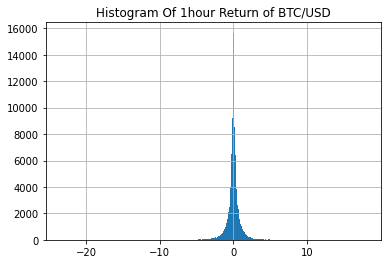

In [5]:
label.hist(bins=500)
plt.title("Histogram Of 1hour Return of BTC/USD")
plt.show()

In [6]:
def nandetector(x, threshold=10):
    return np.sum(np.isnan(x)) > threshold  # true if there is more than 10 nan

def get_input_output(norm_features, label, window=36):
    shape = (len(label), window, norm_features.shape[1])
    input_data = np.zeros(shape)

    for t in range(window):
        input_data[:, t, :] = norm_features.shift(window-1 - t)
        
    flag_nan_input = np.zeros(len(input_data))
    for i in range(len(input_data)):
        flag_nan_input[i] = nandetector(input_data[i])    
    flag_nan_output = label.apply(np.isnan)

    flag_nan = (flag_nan_output.values + flag_nan_input).astype(bool)
    flag_nan = pd.Series(flag_nan, index=label.index)

    ## get inputs, outputs
    inputs = input_data[flag_nan.values==False]
    inputs[np.isnan(inputs)] = 0.0  

    outputs = label.values[flag_nan.values==False]
    return (inputs, outputs, flag_nan )

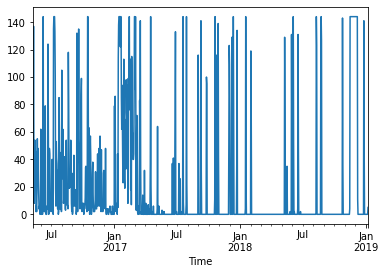

In [7]:
nlags = 36
inputs, outputs, flag_nan = get_input_output(norm_features, label, window=nlags)
flag_nan.groupby(pd.Grouper(freq='d')).sum().plot()

In [8]:
np.save(data_dir + 'inputs', inputs)
np.save(data_dir + 'outputs', outputs)

* Train the model

In [9]:
import keras.backend as K
def right_direction(y_true, y_pred):
    length = K.shape(y_true)[0]
    pmn = K.sum(K.sign(y_true * y_pred)) ## positive - negative
    ppn = K.sum(K.abs(K.sign(y_true * y_pred)))
    wrong_rate = (ppn + pmn) /2/ ppn
    return wrong_rate * 100

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  fig, ax = plt.subplots()
  ax.set_xlabel('Epoch')
  ax.set_ylabel('MAE')
  ax.plot(hist['epoch'], hist['loss'],
           label='Train loss (left axis)')
  ax.legend()
  ax1 = ax.twinx()
  ax1.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss (right axis)', color='r')
#   plt.ylim([0,])
  ax1.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.plot(hist['epoch'], hist['right_direction'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_right_direction'],
           label = 'Val Accuracy', color='r')
#   plt.ylim([0,20])
  plt.legend()

  fig, ax = plt.subplots()
  ax.set_xlabel('Epoch')
  ax.set_ylabel('MSE')
  ax.plot(hist['epoch'], hist['mse'],
           label='Train MSE')
  ax.legend()
  ax1 = ax.twinx()
  ax1.plot(hist['epoch'], hist['val_mse'],
           label = 'Val MSE', color='r')
#   plt.ylim([0,])
  ax1.legend()
  plt.show()


def build_model(units=12, nlags=10, nfeatures=7, seed=1):
#     tf.random.set_seed(seed)
    model = keras.Sequential([
        layers.Dense(8, input_shape=(nlags, nfeatures), activation='relu', kernel_regularizer=keras.regularizers.L2(0.001)),
        layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.001)),
        layers.BatchNormalization(trainable=True),
        layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.0)),
        layers.Dropout(rate=0.2),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, input_shape=(nlags, nfeatures)),
        layers.Dropout(rate=0.2),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='sigmoid'),
        layers.BatchNormalization(trainable=True),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

#     lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    lr=0.001
    
    optimizer = tf.keras.optimizers.Nadam(lr)

    model.compile(loss='mae',
                optimizer=optimizer,
                metrics=[right_direction, 'mse'])
    return model

In [11]:
# The index in input&output dropped a few days, so we need to figure out time matches which index
def time_to_index(time, flag_nan=flag_nan):
    return np.sum(flag_nan[flag_nan.index < time] == False)

# Making predictions, given starttime and endtime
def making_prediction(model, start_time, end_time, flag_nan=flag_nan):
    """
    First, find corresponding valid input samples within this period
    Second, make predictions for the valid samples
    Third, return predictions for every 10-min during this period

    Args:
      model: the trained LSTM model
      start_time: should be no earlier than '2016-05-10 13:30:00' (included)
      end_time: should be no later than '2019-01-07 22:00:00'  (included)
    Return:
      series containing predictions
    """
    start, end = time_to_index(start_time), time_to_index(end_time)+1
    test_data = inputs[start:end]
    test_pred = model.predict(test_data).flatten()
    
    temp_flag = flag_nan.loc[start_time: end_time]
    predictions = pd.Series(np.full(len(temp_flag), np.nan), index=temp_flag.index)
    predictions[temp_flag==False] = test_pred 
    return predictions

In [23]:
# nlags=36
initial_epoch=0
tf.random.set_seed(0)
nfeatures = norm_features.shape[1]
model = build_model(nlags=nlags, nfeatures=nfeatures)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 36, 8)             64        
_________________________________________________________________
dense_7 (Dense)              (None, 36, 12)            108       
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 12)            48        
_________________________________________________________________
dense_8 (Dense)              (None, 36, 12)            156       
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 12)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 36, 12)            1200      
_________________________________________________________________
dropout_3 (Dropout)          (None, 36, 12)           


....................................................................................................
....................................................................................................200


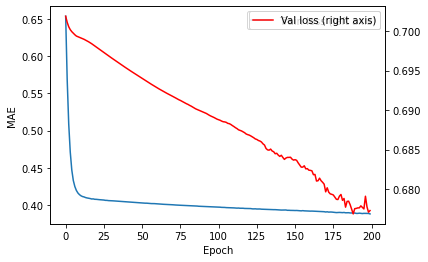

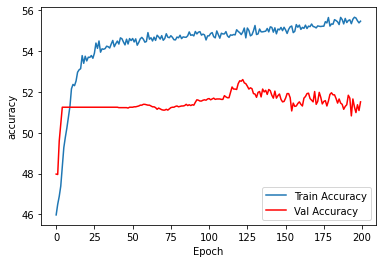

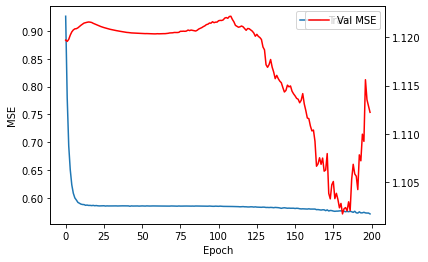

In [24]:
# from sklearn.utils import shuffle

train_start, train_end = "2016-05-12 00:00:00", "2017-07-12 00:00:00"
start, end = time_to_index(train_start), time_to_index(train_end)
train_data = inputs[start:end]
train_label = outputs[start:end]

nbatch = 5
batch_size = int((end-start + 1)*0.9 //nbatch) + 1

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

early_stop = keras.callbacks.EarlyStopping(min_delta=0, verbose=1, patience=200, mode='min', restore_best_weights=True)

log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

EPOCHS = 200
tf.random.set_seed(1)
history = model.fit(
    train_data, train_label, batch_size=batch_size, shuffle=False ,epochs=EPOCHS, validation_split=0.1, 
    verbose=0, callbacks=[PrintDot(), tensorboard_callback, early_stop])#, initial_epoch=initial_epoch)
initial_epoch += EPOCHS
print(initial_epoch)
plot_history(history)

In [44]:
# model.save_weights(data_dir + 'model_weights_best_1')
model.load_weights(data_dir + 'model_weights_best_1')

(3000,) (3000,)


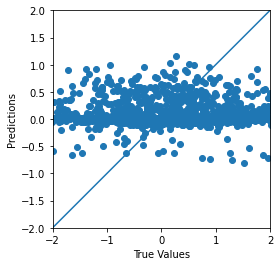

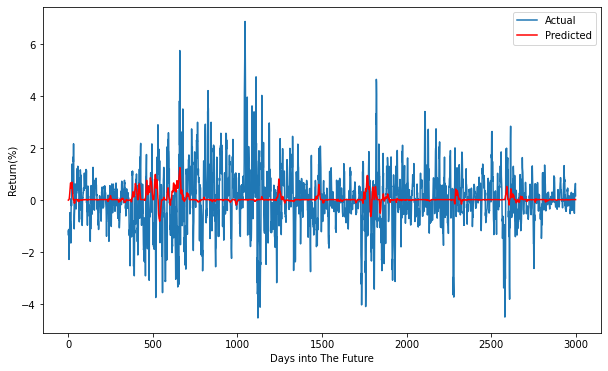

In [14]:
size = 49455
test_data = inputs[size:size+3000]
test_labels = outputs[size:size+3000]
test_predictions = model.predict(test_data).flatten()
print(test_labels.shape, test_predictions.shape)
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
lim=2
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])
_ = plt.plot([-lim, lim], [-lim, lim])

plt.figure(figsize=(10, 6))
plt.plot(test_labels, label='Actual')
plt.plot(test_predictions, label='Predicted', c='r')
plt.ylabel("Return(%)")
plt.xlabel('Days into The Future')
plt.legend()
plt.show()

### Rolling Train
  * Retrain the model: update weights using new data
    * Use only 1 batch to update weights
    * Use Earlystopping to restore the best weights
  * Making predictions for given time period.
  * Build and test the prediction performance on a strategy


In [17]:
# Set the start&end for each train set and test set
first_start = dt.datetime.strptime("2016-05-12 00:00:00", "%Y-%m-%d %H:%M:%S")
first_end = dt.datetime.strptime("2017-07-12 00:00:00", "%Y-%m-%d %H:%M:%S")
training_intervals = []
for i in range(0, 6):
  start = first_start + dt.timedelta(days=90)*i
  end = first_end + dt.timedelta(days=90)*i
  training_intervals.append((start, end))
  print(start, end, f",\t Number of periods: {time_to_index(end)-time_to_index(start)}")

test_starts = [x[1] for x in training_intervals]
test_ends = test_starts[1:] + [dt.datetime(2019, 1, 7, 22, 0, 0)]
testing_intervals = list(zip(test_starts, test_ends))
for i in testing_intervals:
  print(str(i[0]), str(i[1]-dt.timedelta(minutes=10)))

2016-05-12 00:00:00 2017-07-12 00:00:00 ,	 Number of periods: 49455
2016-08-10 00:00:00 2017-10-10 00:00:00 ,	 Number of periods: 51443
2016-11-08 00:00:00 2018-01-08 00:00:00 ,	 Number of periods: 52555
2017-02-06 00:00:00 2018-04-08 00:00:00 ,	 Number of periods: 55214
2017-05-07 00:00:00 2018-07-07 00:00:00 ,	 Number of periods: 57402
2017-08-05 00:00:00 2018-10-05 00:00:00 ,	 Number of periods: 57482
2017-07-12 00:00:00 2017-10-09 23:50:00
2017-10-10 00:00:00 2018-01-07 23:50:00
2018-01-08 00:00:00 2018-04-07 23:50:00
2018-04-08 00:00:00 2018-07-06 23:50:00
2018-07-07 00:00:00 2018-10-04 23:50:00
2018-10-05 00:00:00 2019-01-07 21:50:00


In [18]:
# Retrain the model
def update_model(train_start, train_end):
  
  print(f"Training On Samples During {str(train_start)} and {str(train_end)}")
  start, end = time_to_index(train_start), time_to_index(train_end)

  train_data = inputs[start:end]
  train_label = outputs[start:end]
  batch_size = int((end-start + 1) * 0.9 //5)

  early_stop = keras.callbacks.EarlyStopping(min_delta=0, verbose=1, patience=20, mode='min', restore_best_weights=True)

  log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  EPOCHS = 100
  tf.random.set_seed(1)
  history = model.fit(
      train_data, train_label, batch_size=batch_size*6, shuffle=False, epochs=EPOCHS, validation_split=0.1, 
      verbose=0, callbacks=[PrintDot(), early_stop])#, initial_epoch=initial_epoch)

  plot_history(history)

Training On Samples During 2016-08-10 00:00:00 and 2017-10-10 00:00:00

...............................................................Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping


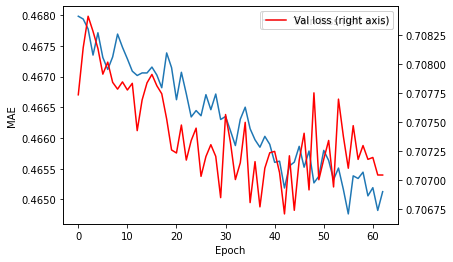

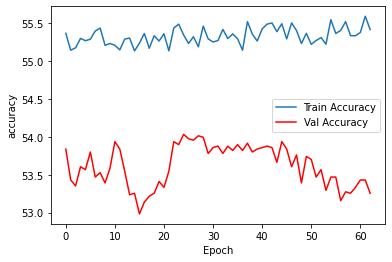

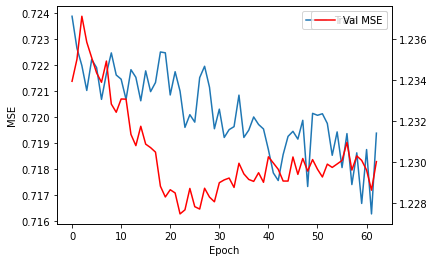

Training On Samples During 2016-11-08 00:00:00 and 2018-01-08 00:00:00

.........................................................Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping


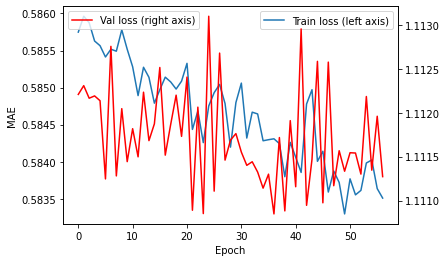

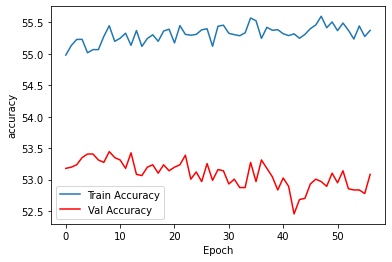

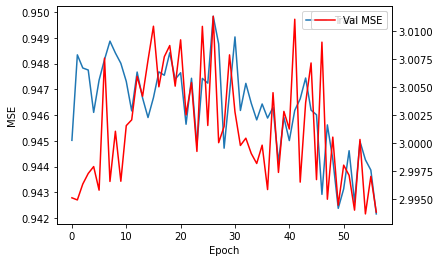

Training On Samples During 2017-02-06 00:00:00 and 2018-04-08 00:00:00

...................................................Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping


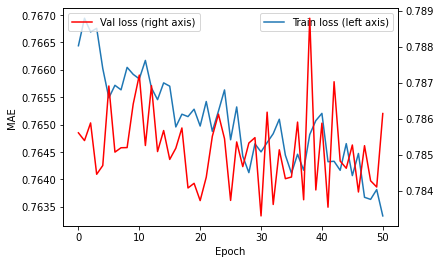

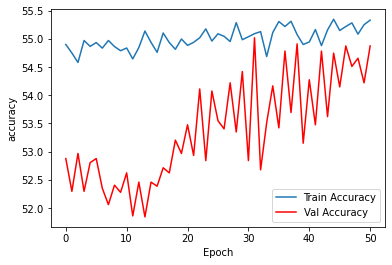

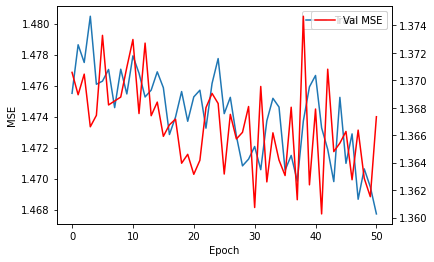

Training On Samples During 2017-05-07 00:00:00 and 2018-07-07 00:00:00

..............................Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping


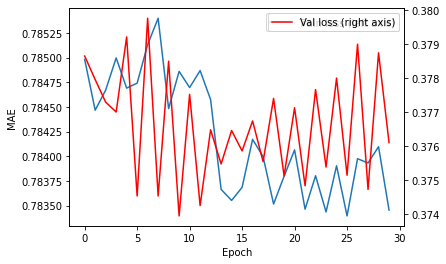

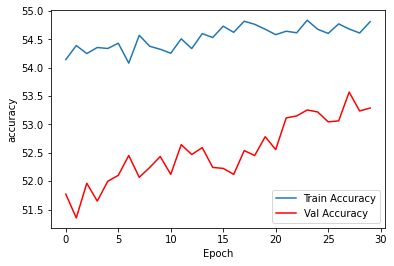

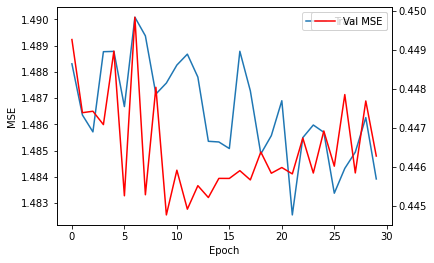

Training On Samples During 2017-08-05 00:00:00 and 2018-10-05 00:00:00

............................Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


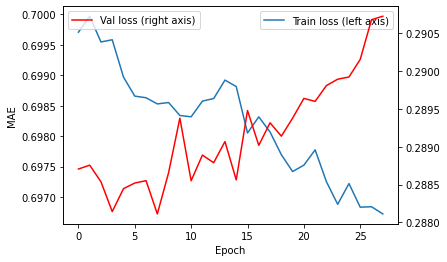

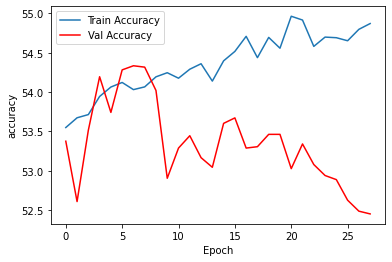

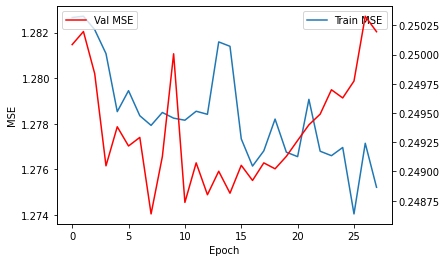

In [26]:
pred_start, pred_end = testing_intervals[0][0], testing_intervals[-1][-1]
index = flag_nan.loc[pred_start: pred_end].index
predictions = pd.Series(np.full(len(index), np.nan), index=index)  # to store predictions
for i in range(len(training_intervals)):
  test_start, test_end = testing_intervals[i]
  preds = making_prediction(model, test_start, test_end)
  predictions.loc[preds.index] = preds
  # update the model
  if i+1 < len(training_intervals):
    train_start, train_end = training_intervals[i+1]
    update_model(train_start, train_end)

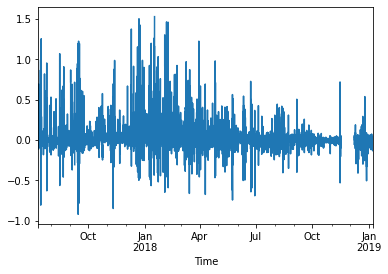

In [28]:
predictions.plot()

predictions.to_csv(data_dir + 'predictions.csv')

Model MAE =  0.6157915985608543 	Benchmark MAE =  0.6412375908803221
Model MSE =  1.0816943268166666 	Benchmark MSE =  1.1842814436238613
IC = 0.08934345584463221


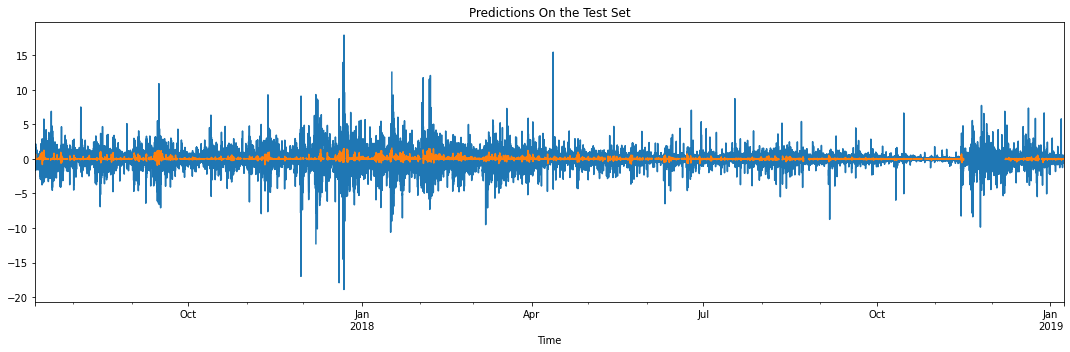

In [35]:
label_test = label.loc['2017-07-12 00:00:00':'2019-01-07 22:00:00']
print("Model MAE = ",np.mean(np.abs(predictions - label_test)), "\tBenchmark MAE = ",np.mean(np.abs(label_test)))
print('Model MSE = ',np.mean(np.abs(predictions - label_test)**2), '\tBenchmark MSE = ',np.mean(np.abs(label_test)**2))
print(f'IC = {predictions.corr(label_test)}')
fig, ax = plt.subplots(figsize=(15,5))

label_test.plot(ax=ax)
predictions.plot(ax=ax)
ax.set_title("Predictions On the Test Set")
fig.tight_layout()
plt.show()

### Building Strategy

In [40]:
def test_signal(y_pre, threshold=1):
    flag_p = y_pre > threshold
    flag_n = y_pre < -threshold
    return (flag_p, flag_n)

def stra_performance(flag_n, flag_p, ret_23, label='long-short', mode='test'):
    time = ret_23.index
    ret_23 = ret_23.values
    stra_ret = np.zeros(len(ret_23))
    # flag = (trends[11] > 0) & (trends[11]<5)
    # flag_1 = (trends_1[11] < 0) & (trends_1[11]>-5)
    dates = range(len(ret_23))
    flag_p = flag_p.squeeze()
    flag_n = flag_n.squeeze()
    stra_ret[flag_n] = ret_23[flag_n]
    stra_ret[flag_p] = -ret_23[flag_p]
    stra_ret[np.isnan(stra_ret)] = 0
    count_trades = np.count_nonzero(stra_ret)
    print(label, ": ")
    print("# of trading：", count_trades, ";   winning rate：", np.count_nonzero(stra_ret > 0) / count_trades)
    stra_ret = pd.Series(stra_ret, index=time)
    daily_ret = stra_ret.groupby(pd.Grouper(freq='d')).sum()
    Sharpe = daily_ret.mean() / daily_ret.std() * np.sqrt(365)
    print("Sharpe：", Sharpe)
    earnings = np.cumsum(daily_ret)
    earnings.plot()
    plt.legend(["Sharpe Ratio = {:.4}".format(Sharpe)])
    plt.xlabel("Dates")
    plt.ylabel("Earning")
    plt.title("Return on {} set".format(mode))
    plt.show()
    return stra_ret
    
def back_test(model, start_time, end_time, threshold=0.5, ret_10min=ret_10min, mode='test'):
    if model: test_predictions = making_prediction(model, start_time, end_time)
    else: test_predictions = predictions.loc[start_time:end_time]
    flag_p, flag_n = test_signal(test_predictions.values, threshold)
    stra_performance(flag_p, flag_n, ret_10min.loc[start_time: end_time], mode=mode)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


long-short : 
# of trading： 4763 ;   winning rate： 0.529708167121562
Sharpe： 3.452862579031557


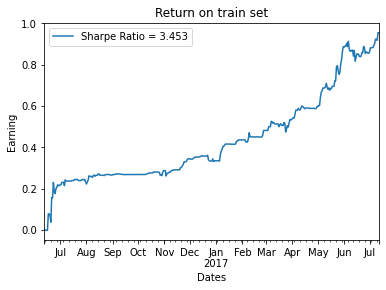

In [45]:
_ = back_test(model, '2016-06-12 00:00:00', '2017-07-12 00:00:00', threshold=0.05, mode='train')

long-short : 
# of trading： 14481 ;   winning rate： 0.5241350735446447
Sharpe： 4.01387374344729


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


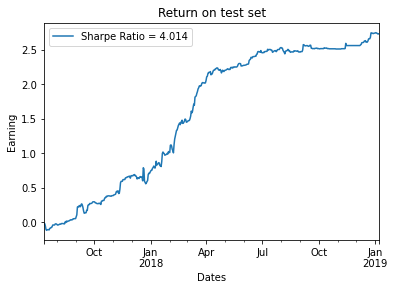

In [42]:
back_test(None, '2017-07-12 00:00:00', '2019-01-07 00:00:00', threshold=0.05, mode='test')

* Compare to the benchmark

In [46]:
BTCUSD = pd.read_csv(data_dir + 'BTC-USD.csv', index_col=0, parse_dates=True)
BTCUSD

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
...,...,...,...,...,...,...
2020-08-15,11768.697266,11963.203125,11768.697266,11865.698242,11865.698242,2.335492e+10
2020-08-16,11866.685547,11934.901367,11737.188477,11892.803711,11892.803711,2.058338e+10
2020-08-17,11895.658203,12359.056641,11806.696289,12254.402344,12254.402344,2.822769e+10


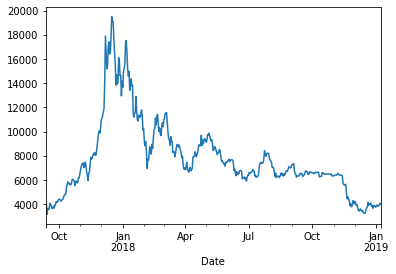

In [ ]:
BTCUSD.Close.loc['2017-09-12':'2019-01-07'].plot()

* We can say ignoring costs and fractions, this strategy significantly beat the market.

* Is it possible to build this into a practically profitable strategy?